# QRDO Supply and Allocation - Historical Analysis

#### Maria Silva, May 2023

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## Token Allocation

In [2]:
file = os.path.realpath("../data/qrdo_allocation_overview.csv")
allocation_df = pd.read_csv(file)
allocation_df["cliff_date"] = pd.to_datetime(allocation_df["cliff_date"])
allocation_df = allocation_df.fillna(0)

alloc_agg_df = (
    allocation_df
    #[allocation_df["pool_type"] != "Burned"]
    .groupby("pool_group")
    [['total', 'vested', 'to_vest']]
    .sum()
    .reset_index()
)
alloc_agg_df["group"] = alloc_agg_df["pool_group"].str.title()
alloc_agg_df = alloc_agg_df[['group', 'total', 'vested', 'to_vest']].set_index("group")
alloc_agg_df.loc["Seed Round",:] = alloc_agg_df.loc["Early Seed",:] + alloc_agg_df.loc["Late Seed",:]
alloc_agg_df = alloc_agg_df.drop(["Early Seed", "Late Seed"]).reset_index()
alloc_agg_df

,group,total,vested,to_vest
0,Advisors,24301596.0,4272808.08,2.002879e+07
1,Ecosystem,110000000.0,44423076.92,6.557692e+07
2,Option Holders,129741764.0,22811738.73,1.069300e+08
3,Private Sale,77293333.0,56483589.74,2.080974e+07
4,Public Sale,37020989.0,37020989.32,0.000000e+00
5,Qredo,100000000.0,0.00,0.000000e+00
6,Treasury,42014998.0,13574076.30,2.844092e+07
7,Team,226627326.0,40910781.05,1.857165e+08
8,Validators,40000000.0,0.00,0.000000e+00
9,Seed Round,212999997.0,39647989.45,1.733520e+08


In [3]:
alloc_agg_df[['total', 'vested', 'to_vest']].sum()

total      1.000000e+09
vested     2.591450e+08
to_vest    6.008550e+08
dtype: float64

In [4]:
np.round(alloc_agg_df[['total', 'vested', 'to_vest']].sum()["vested"])

259145050.0

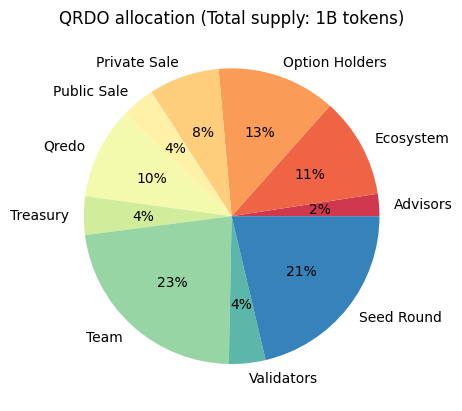

In [5]:
colors = sns.color_palette('Spectral', n_colors=len(alloc_agg_df))
plt.pie(alloc_agg_df["total"].values, labels = alloc_agg_df["group"].values, colors = colors, autopct='%.0f%%')
plt.title("QRDO allocation (Total supply: 1B tokens)")
plt.show()

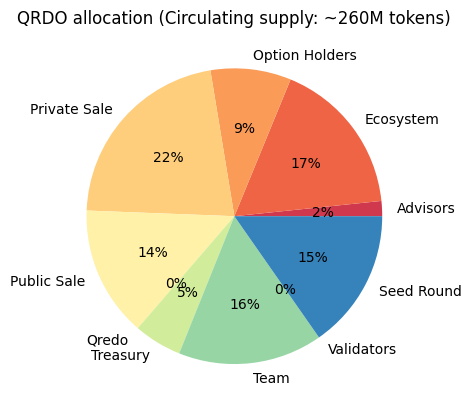

In [6]:
colors = sns.color_palette('Spectral', n_colors=len(alloc_agg_df))
plt.pie(alloc_agg_df["vested"].values, labels = alloc_agg_df["group"].values, colors = colors, autopct='%.0f%%')
plt.title("QRDO allocation (Circulating supply: ~260M tokens)")
plt.show()

Least vested groups:

In [7]:
alloc_agg_df.sort_values("to_vest", ascending=False)

,group,total,vested,to_vest
7,Team,226627326.0,40910781.05,1.857165e+08
9,Seed Round,212999997.0,39647989.45,1.733520e+08
2,Option Holders,129741764.0,22811738.73,1.069300e+08
1,Ecosystem,110000000.0,44423076.92,6.557692e+07
6,Treasury,42014998.0,13574076.30,2.844092e+07
3,Private Sale,77293333.0,56483589.74,2.080974e+07
0,Advisors,24301596.0,4272808.08,2.002879e+07
4,Public Sale,37020989.0,37020989.32,0.000000e+00
5,Qredo,100000000.0,0.00,0.000000e+00
8,Validators,40000000.0,0.00,0.000000e+00


## Vesting schedule (current allocation)

In [8]:
file = os.path.realpath("../data/current_vesting_schedule.csv")
raw_df = pd.read_csv(file)
raw_df["date"] = pd.to_datetime(raw_df["date"])

main_vars = ['Option Holders', 'Seed Round', 'Team', 'Advisors','Private Sale', 'Ecosystem', 'Treasury']
cum_vest_df = raw_df[main_vars].cumsum()/(10**6)

vested_dict = {var: alloc_agg_df[alloc_agg_df["group"]==var]["vested"].values[0] for var in main_vars}
vested_series = pd.Series(vested_dict)/(10**6)

cum_vest_df = cum_vest_df + vested_series
total_vested = alloc_agg_df[['total', 'vested', 'to_vest']].sum()["vested"]/(10**6)
cum_vest_df["Others"] = total_vested - vested_series.sum()
main_vars_2 = ["Others"] + main_vars
cum_vest_df = cum_vest_df[main_vars_2]

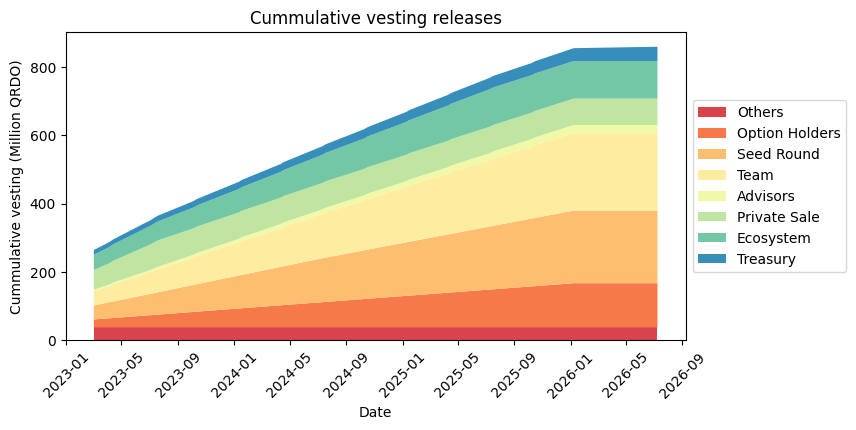

In [9]:
# Data
colors = sns.color_palette('Spectral', n_colors=len(main_vars_2))
x = raw_df["date"].values
y = cum_vest_df.T.values
 
# Plot
plt.figure(figsize=(8,4))
plt.stackplot(x,y, labels=main_vars_2, colors=colors)
plt.xticks(rotation=45)
plt.ylabel("Cummulative vesting (Million QRDO)") 
plt.xlabel("Date") 
plt.legend(loc='upper left')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Cummulative vesting releases")
plt.show()

In [10]:
np.round(cum_vest_df.iloc[-1].sum())

860.0

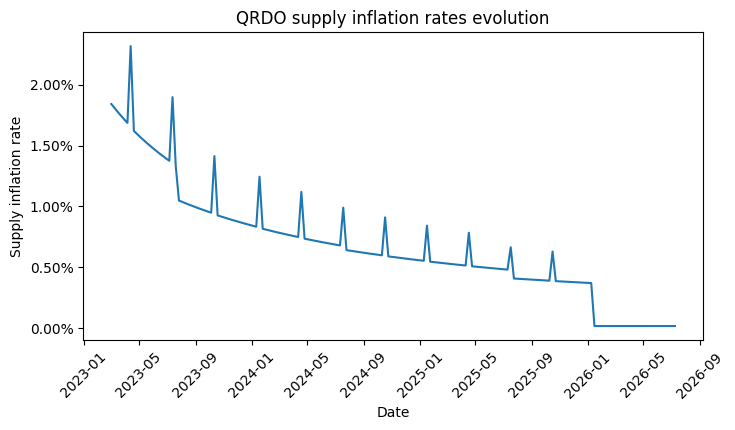

In [11]:
inflation_df = pd.DataFrame()
inflation_df["date"] = raw_df["date"]
inflation_df["vesting"] = raw_df[main_vars].sum(axis=1)/(10**6)
inflation_df["inflation_rate"] = inflation_df["vesting"]/cum_vest_df.sum(axis=1)


# Plot
plt.figure(figsize=(8,4))
fig = sns.lineplot(data=inflation_df, x="date",y="inflation_rate")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.xticks(rotation=45)
plt.title("QRDO supply inflation rates evolution") 
plt.xlabel("Date") 
plt.ylabel("Supply inflation rate")
plt.show()

## Circulating supply at 2023/06/15

In [12]:
temp_df = cum_vest_df.copy()
temp_df["date"] = raw_df["date"].values
temp_df[temp_df["date"]>=dt.datetime(2023, 6, 13)].iloc[:2]

,Others,Option Holders,Seed Round,Team,Advisors,Private Sale,Ecosystem,Treasury,date
15,37.020989,34.217608,59.471984,60.377969,6.409212,72.338632,52.884615,16.159615,2023-06-15
16,37.020989,34.930475,60.710984,61.471143,6.542737,73.329573,53.413461,16.321211,2023-06-22


In [14]:
np.round(cum_vest_df[raw_df["date"]==dt.datetime(2023, 6, 15)].iloc[0].sum())

339.0